In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:1')
print(device)

cuda:1


In [3]:
class Hyperparameter():
    def __init__(self):
        self.dict = {}
        self.dict['optimizer'] = {}
        self.dict['optimizer']['lr'] = [1e-4, 5.5e-6]
        self.dict['optimizer']['beta'] = [(0.9, 0.999), (0.9, 0.999)]
        self.dict['optimizer']['eps'] = [1e-7, 1e-7]
        self.dict['optimizer']['method'] = 'Adam'
    
        self.dict['epoch'] = [100, 50]
        self.dict['batch_size'] = 32
        self.dict['patience'] = 20
        self.dict['min_delta'] = 1e-4
        
        self.dict['training_data'] = {}
        self.dict['training_data']['path'] = '/home/chenyu/Desktop/CNNmeasurement/TrainingData_CoarseCNN/'
        self.dict['training_data']['data'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy'
        self.dict['training_data']['label_1'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_45mradnewEmit_x25000.npy'
        self.dict['training_data']['label_2'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy'
        self.dict['training_data']['split'] = 0.8
        self.dict['training_data']['aperture'] = 45
        self.dict['training_data']['limit'] = 50
        
        self.dict['segmentation'] = {}
        self.dict['segmentation']['resize'] = (135, 135)
        self.dict['segmentation']['ratio'] = (0.97, 1.03)
        self.dict['segmentation']['scale'] = (0.9, 1.0)
        self.dict['segmentation']['normalize'] = None
        
        self.dict['architecture'] = {}
        self.dict['architecture']['dropout'] = 0.5
        self.dict['architecture']['linear_shape'] = [512]
        
        self.process = {}
        
        self.process['training'] = []
        self.process['validation'] = []
        
    def add_training_process(self, training_acc, validation_acc, epoch):
        if epoch == 0:
            self.process['training'].append([])
            self.process['validation'].append([])
        if torch.is_tensor(training_acc):
            training_acc = training_acc.cpu().detach().numpy()
        if torch.is_tensor(validation_acc):
            validation_acc = validation_acc.cpu().detach().numpy()
        self.process['training'][-1].append(training_acc)
        self.process['validation'][-1].append(validation_acc)
        return
    
    def save_result(self, path):
        with open(path + 'hyperparameter.pkl', 'wb') as f:
            pickle.dump(self.dict, f)
        with open(path + 'training_log.pkl', 'wb') as f:
            pickle.dump(self.process, f)

In [4]:
par = Hyperparameter()

In [5]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from torch.jit.annotations import List


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, 1)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


def _load_state_dict(model, model_url, progress):
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)

In [6]:
# prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [7]:
input_path = par.dict['training_data']['path']
train_data = np.load(input_path + par.dict['training_data']['data'])
print(train_data.shape)

train_label = np.load(input_path + par.dict['training_data']['label_1'])
train_label_1 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = np.load(input_path + par.dict['training_data']['label_2'])
train_label_2 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = (train_label_1 + train_label_2) / 2

(25010, 128, 128)
(25010,)
(25010,)


In [8]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

In [9]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [10]:
if par.dict['training_data']['aperture'] != 0:
    aperture_mask = aperture_generator(128, par.dict['training_data']['limit'], 
                                       par.dict['training_data']['aperture'])

In [11]:
class RonchigramDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = scale_range(self.data[index,:,:].astype('float'), 0, 1)
        if par.dict['training_data']['aperture'] != 0:
            img = img * aperture_mask
        new_channel = np.zeros(img.shape)
        img = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img * 255))
        y_label = torch.tensor(float(self.labels[index]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [12]:
transform = transforms.Compose(
        [
            transforms.Resize(par.dict['segmentation']['resize']),
            transforms.RandomResizedCrop((128, 128), scale = par.dict['segmentation']['scale'], ratio = par.dict['segmentation']['ratio']),
            transforms.ToTensor(),
            # TODO: need to add random shear here
            # option to normalize a tensor with mean and standard deviation, similar to featurewise center in Keras
#             transforms.Normalize((1.0, 1.0, 1.0), (1.0, 1.0, 1.0)),
        ]
    )

In [13]:
# training hyperparameters
train_CNN = False
batch_size = par.dict['batch_size']
shuffle = True
pin_memory = True
num_workers = 1

In [14]:
dataset = RonchigramDataset(train_data, train_label, transform = transform)

n_train = int(len(train_data) * par.dict['training_data']['split'])
n_val = len(train_data) - n_train
train_set, validation_set = torch.utils.data.random_split(dataset,[n_train,n_val])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

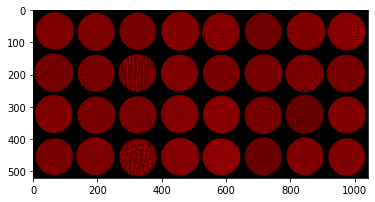

In [16]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.colorbar()
    plt.show()
    
imshow(torchvision.utils.make_grid(images))

In [17]:
model = DenseNet( 32, (6, 12, 32, 32), 64, drop_rate = 0.3).to(device)
criterion = nn.MSELoss(reduction = 'mean')
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    sum_MSE = 0
    counter = 0
    loss = nn.MSELoss(reduction = 'mean')
    model.eval()
    
    # define two lists to save truth and predictions, for the plot only.
    y_list = torch.empty(0).to(device = device)
    pred_list = torch.empty(0).to(device = device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            pred = torch.squeeze(model(x))
            pred_list = torch.cat((pred_list, pred), 0)
            y_list = torch.cat((y_list, y), 0)
            sum_MSE += loss(pred, y) * y.shape[0]
            counter += y.shape[0]
    
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    img = ax.scatter(y_list.cpu().numpy(), pred_list.cpu().numpy(), s = 1)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100),'--', c = 'red')
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Truth',fontsize = 16)
    ax.set_ylabel('Prediction', fontsize = 16)
    plt.show()
    
    model.train()
#     print( f"Got accuracy {float(sum_MSE)/float(counter):.6f}" )   
    return f"{float(sum_MSE)/float(counter):.6f}"
    
#     model.train()

In [19]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience = 5, min_delta = 0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [20]:
def train():
    early_stopping = EarlyStopping(patience = par.dict['patience'], min_delta = par.dict['min_delta'])
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        
        if epoch % 2 == 0:
            val_acc = check_accuracy(validation_loader, model)
            loop.set_postfix(val_acc = val_acc)
            early_stopping(float(val_acc))
            if early_stopping.early_stop:
                par.add_training_process(acc_loss / counter , float(val_acc), epoch)
                break
                
        acc_loss = 0
        counter = 0
        
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = torch.squeeze(model(imgs))
            loss = criterion(outputs, labels)
            acc_loss += loss * labels.shape[0]
            counter += labels.shape[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())
        
        par.add_training_process(acc_loss / counter , val_acc, epoch)
        print(f"Training acc: {float(acc_loss) / float(counter):.6f}, Validation accuracy {float(val_acc):.6f}")

  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


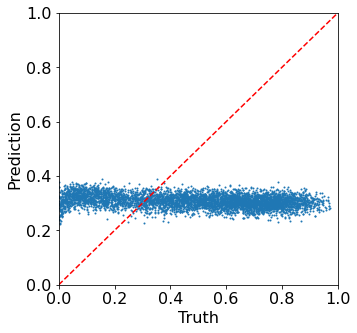

Epoch [0/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.55it/s, loss=0.0142]


Training acc: 0.031214, Validation accuracy 0.104008


Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.59it/s, loss=0.0185]


Training acc: 0.020020, Validation accuracy 0.104008


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


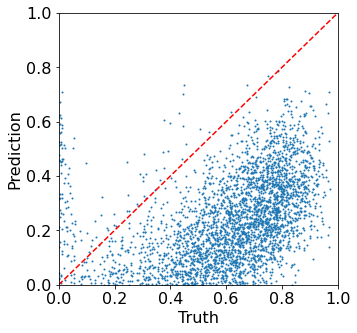

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.205271]

INFO: Early stopping counter 1 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [2/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.55it/s, loss=0.00776]


Training acc: 0.014994, Validation accuracy 0.205271


Epoch [3/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.84it/s, loss=0.0132]


Training acc: 0.012609, Validation accuracy 0.205271


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


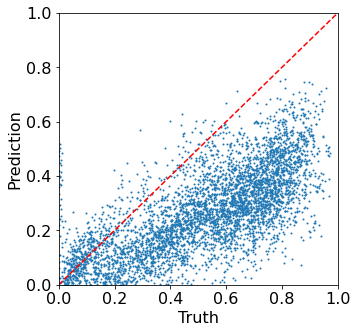

Epoch [4/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:21<00:00,  4.43it/s, loss=0.0111]


Training acc: 0.011260, Validation accuracy 0.089618


Epoch [5/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.63it/s, loss=0.00417]


Training acc: 0.010412, Validation accuracy 0.089618


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


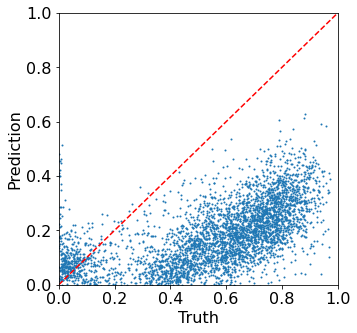

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.175071]

INFO: Early stopping counter 2 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [6/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.56it/s, loss=0.00943]


Training acc: 0.009106, Validation accuracy 0.175071


Epoch [7/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.63it/s, loss=0.00492]


Training acc: 0.008407, Validation accuracy 0.175071


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


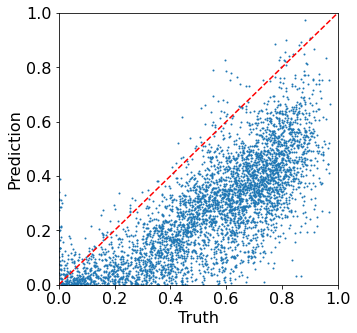

Epoch [8/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:25<00:00,  4.31it/s, loss=0.00628]


Training acc: 0.007651, Validation accuracy 0.085840


Epoch [9/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:11<00:00,  4.75it/s, loss=0.0046]


Training acc: 0.007155, Validation accuracy 0.085840


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


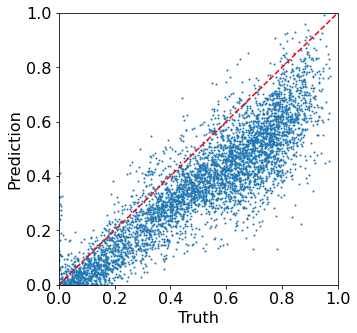

Epoch [10/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.52it/s, loss=0.0052]


Training acc: 0.006443, Validation accuracy 0.031438


Epoch [11/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:12<00:00,  4.72it/s, loss=0.00406]


Training acc: 0.006372, Validation accuracy 0.031438


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


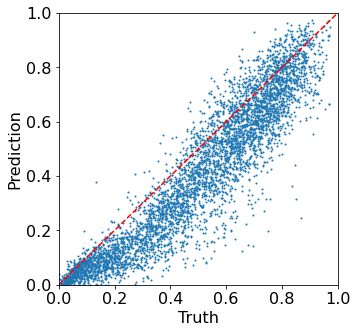

Epoch [12/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.55it/s, loss=0.00696]


Training acc: 0.005721, Validation accuracy 0.016784


Epoch [13/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:11<00:00,  4.76it/s, loss=0.00586]


Training acc: 0.005549, Validation accuracy 0.016784


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


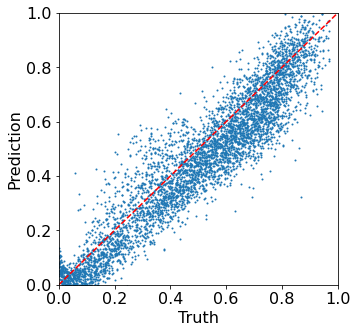

Epoch [14/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:19<00:00,  4.48it/s, loss=0.00136]


Training acc: 0.005278, Validation accuracy 0.009983


Epoch [15/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.84it/s, loss=0.0048]


Training acc: 0.004895, Validation accuracy 0.009983


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


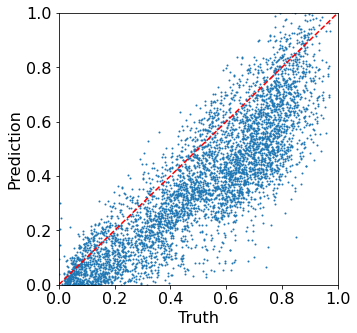

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.032800]

INFO: Early stopping counter 3 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [16/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.51it/s, loss=0.00782]


Training acc: 0.004647, Validation accuracy 0.032800


Epoch [17/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:11<00:00,  4.78it/s, loss=0.0107]


Training acc: 0.004596, Validation accuracy 0.032800


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


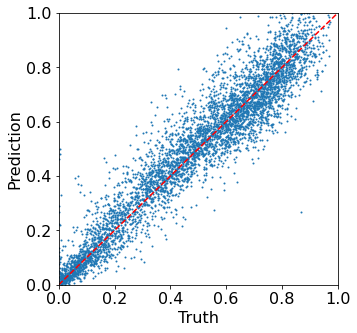

Epoch [18/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.52it/s, loss=0.00624]


Training acc: 0.004362, Validation accuracy 0.006890


Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:12<00:00,  4.74it/s, loss=0.0037]


Training acc: 0.004155, Validation accuracy 0.006890


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


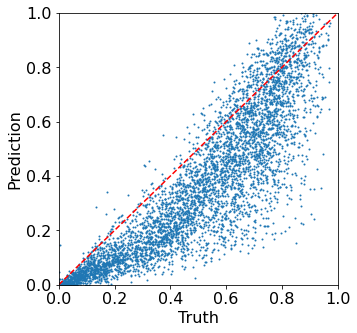

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.033546]

INFO: Early stopping counter 4 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [20/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:19<00:00,  4.49it/s, loss=0.00604]


Training acc: 0.004062, Validation accuracy 0.033546


Epoch [21/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:13<00:00,  4.69it/s, loss=0.00269]


Training acc: 0.003864, Validation accuracy 0.033546


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


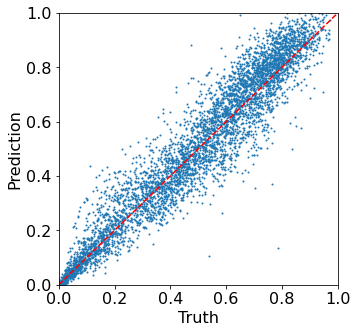

Epoch [22/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:20<00:00,  4.45it/s, loss=0.00505]


Training acc: 0.003668, Validation accuracy 0.006600


Epoch [23/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:12<00:00,  4.71it/s, loss=0.00577]


Training acc: 0.003523, Validation accuracy 0.006600


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


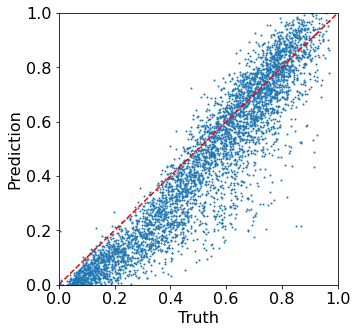

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.015215]

INFO: Early stopping counter 5 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [24/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:20<00:00,  4.47it/s, loss=0.00225]


Training acc: 0.003522, Validation accuracy 0.015215


Epoch [25/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.86it/s, loss=0.00423]


Training acc: 0.003548, Validation accuracy 0.015215


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


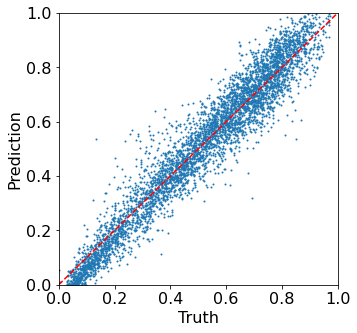

Epoch [26/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:19<00:00,  4.49it/s, loss=0.00316]


Training acc: 0.003212, Validation accuracy 0.004637


Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:12<00:00,  4.73it/s, loss=0.0063]


Training acc: 0.003137, Validation accuracy 0.004637


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


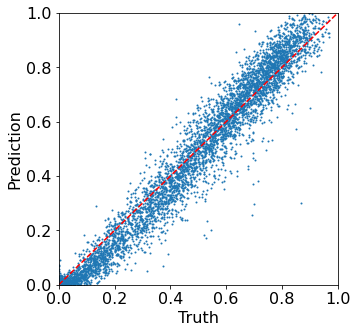

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005046]

INFO: Early stopping counter 6 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [28/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:21<00:00,  4.44it/s, loss=0.00762]


Training acc: 0.003054, Validation accuracy 0.005046


Epoch [29/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.82it/s, loss=0.0079]


Training acc: 0.002944, Validation accuracy 0.005046


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


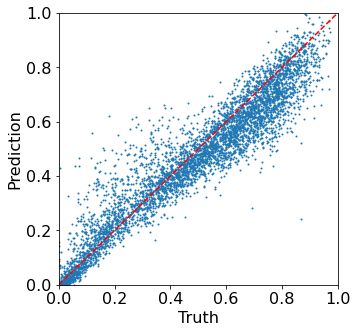

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.007630]

INFO: Early stopping counter 7 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [30/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.53it/s, loss=0.00256]


Training acc: 0.002840, Validation accuracy 0.007630


Epoch [31/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.83it/s, loss=0.00286]


Training acc: 0.002836, Validation accuracy 0.007630


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


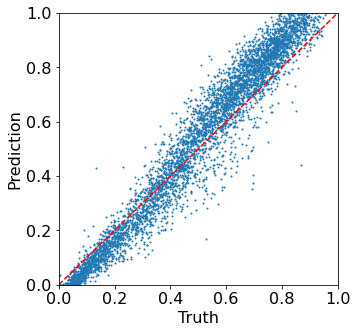

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.007790]

INFO: Early stopping counter 8 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [32/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:21<00:00,  4.43it/s, loss=0.00122]


Training acc: 0.002898, Validation accuracy 0.007790


Epoch [33/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:11<00:00,  4.75it/s, loss=0.00425]


Training acc: 0.002758, Validation accuracy 0.007790


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


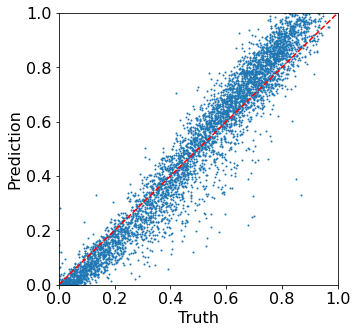

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006948]

INFO: Early stopping counter 9 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [34/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.60it/s, loss=0.00163]


Training acc: 0.002672, Validation accuracy 0.006948


Epoch [35/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.83it/s, loss=0.00601]


Training acc: 0.002615, Validation accuracy 0.006948


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


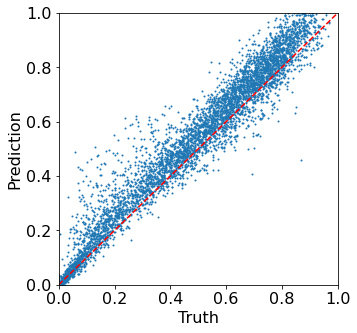

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006828]

INFO: Early stopping counter 10 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [36/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:24<00:00,  4.34it/s, loss=0.00637]


Training acc: 0.002523, Validation accuracy 0.006828


Epoch [37/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.86it/s, loss=0.00464]


Training acc: 0.002556, Validation accuracy 0.006828


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


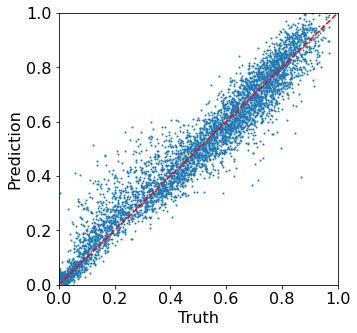

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.004671]

INFO: Early stopping counter 11 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [38/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.54it/s, loss=0.00152]


Training acc: 0.002392, Validation accuracy 0.004671


Epoch [39/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:06<00:00,  4.94it/s, loss=0.00126]


Training acc: 0.002374, Validation accuracy 0.004671


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


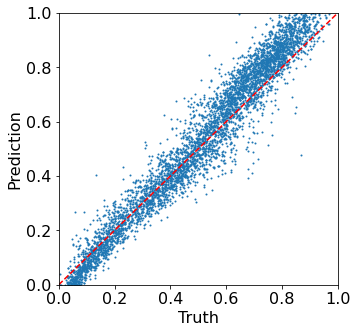

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005252]

INFO: Early stopping counter 12 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [40/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:14<00:00,  4.67it/s, loss=0.00316]


Training acc: 0.002367, Validation accuracy 0.005252


Epoch [41/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.00198]


Training acc: 0.002339, Validation accuracy 0.005252


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


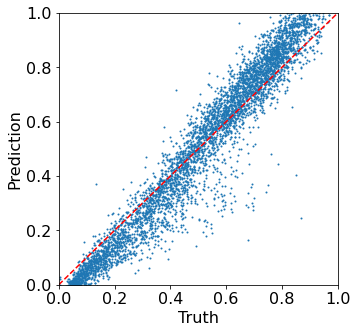

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.007115]

INFO: Early stopping counter 13 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [42/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.56it/s, loss=0.00228]


Training acc: 0.002174, Validation accuracy 0.007115


Epoch [43/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:10<00:00,  4.79it/s, loss=0.00132]


Training acc: 0.002171, Validation accuracy 0.007115


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


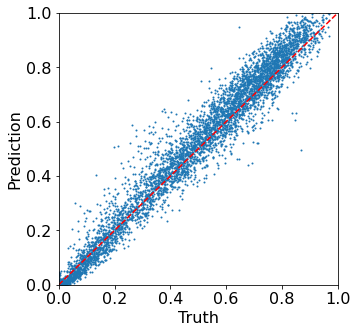

Epoch [44/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:14<00:00,  4.64it/s, loss=0.00194]


Training acc: 0.002093, Validation accuracy 0.003940


Epoch [45/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.86it/s, loss=0.0036]


Training acc: 0.002048, Validation accuracy 0.003940


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


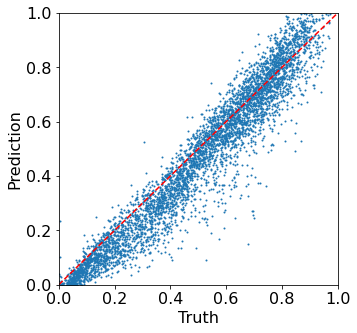

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006762]

INFO: Early stopping counter 14 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [46/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.56it/s, loss=0.00276]


Training acc: 0.002023, Validation accuracy 0.006762


Epoch [47/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.88it/s, loss=0.00141]


Training acc: 0.002042, Validation accuracy 0.006762


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


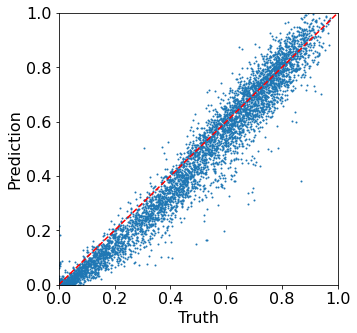

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005075]

INFO: Early stopping counter 15 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [48/100]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.55it/s, loss=0.000628]


Training acc: 0.001949, Validation accuracy 0.005075


Epoch [49/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:06<00:00,  4.95it/s, loss=0.00323]


Training acc: 0.001917, Validation accuracy 0.005075


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


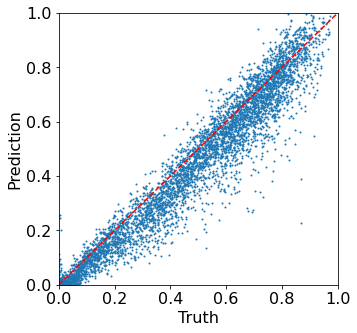

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.006857]

INFO: Early stopping counter 16 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [50/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.51it/s, loss=0.00285]


Training acc: 0.001803, Validation accuracy 0.006857


Epoch [51/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.83it/s, loss=0.00263]


Training acc: 0.001859, Validation accuracy 0.006857


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


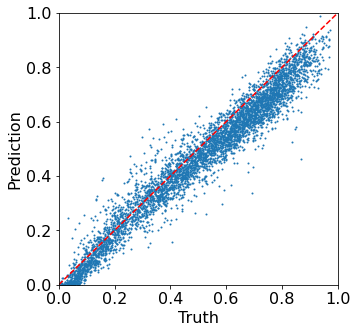

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.004551]

INFO: Early stopping counter 17 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [52/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.58it/s, loss=0.00293]


Training acc: 0.001775, Validation accuracy 0.004551


Epoch [53/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.83it/s, loss=0.00118]


Training acc: 0.001785, Validation accuracy 0.004551


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


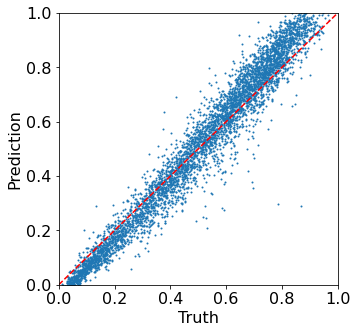

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.004679]

INFO: Early stopping counter 18 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [54/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.55it/s, loss=0.00338]


Training acc: 0.001780, Validation accuracy 0.004679


Epoch [55/100]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.63it/s, loss=0.000982]


Training acc: 0.001670, Validation accuracy 0.004679


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


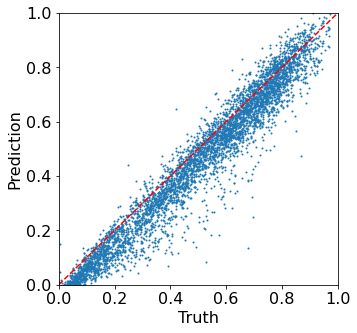

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.005686]

INFO: Early stopping counter 19 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [56/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.57it/s, loss=0.00208]


Training acc: 0.001614, Validation accuracy 0.005686


Epoch [57/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:22<00:00,  4.40it/s, loss=0.00215]


Training acc: 0.001643, Validation accuracy 0.005686


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


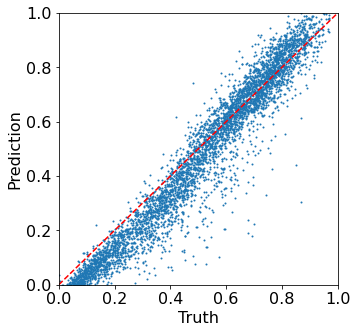

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.007059]

INFO: Early stopping counter 20 of 20
INFO: Early stopping


In [21]:
stage = 0
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


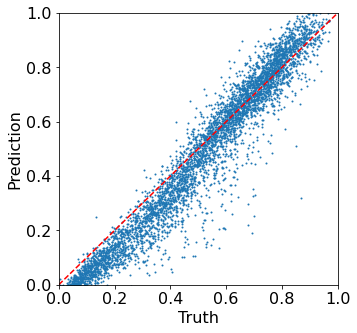

Epoch [0/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.60it/s, loss=0.00124]


Training acc: 0.001133, Validation accuracy 0.007004


Epoch [1/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:04<00:00,  5.03it/s, loss=0.000512]


Training acc: 0.001085, Validation accuracy 0.007004


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


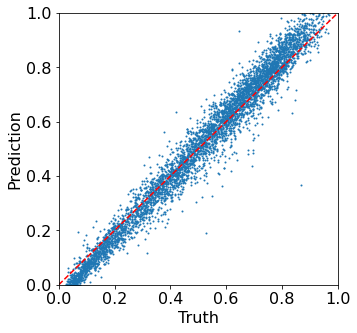

Epoch [2/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:20<00:00,  4.46it/s, loss=0.00144]


Training acc: 0.001060, Validation accuracy 0.002682


Epoch [3/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:13<00:00,  4.67it/s, loss=0.000977]


Training acc: 0.001054, Validation accuracy 0.002682


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


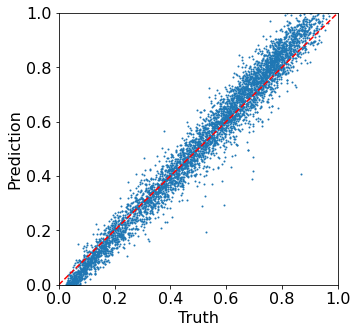

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002865]

INFO: Early stopping counter 1 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [4/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.51it/s, loss=0.00213]


Training acc: 0.001042, Validation accuracy 0.002865


Epoch [5/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.000248]


Training acc: 0.001049, Validation accuracy 0.002865


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


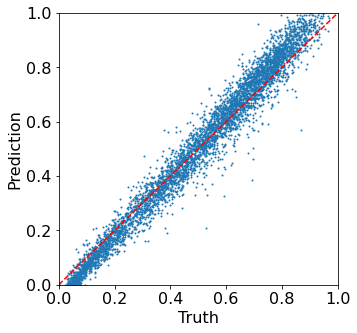

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002907]

INFO: Early stopping counter 2 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [6/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:21<00:00,  4.43it/s, loss=0.00134]


Training acc: 0.001017, Validation accuracy 0.002907


Epoch [7/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.88it/s, loss=0.00177]


Training acc: 0.001006, Validation accuracy 0.002907


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


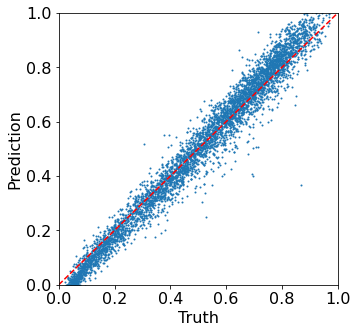

Epoch [8/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.52it/s, loss=0.000541]


Training acc: 0.000995, Validation accuracy 0.002573


Epoch [9/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.83it/s, loss=0.00152]


Training acc: 0.000994, Validation accuracy 0.002573


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


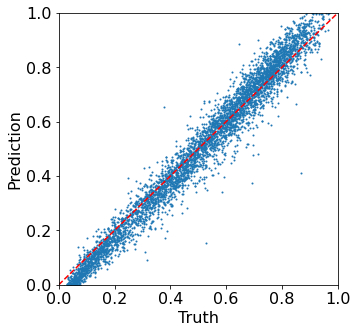

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002657]

INFO: Early stopping counter 3 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [10/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:21<00:00,  4.43it/s, loss=0.00123]


Training acc: 0.000990, Validation accuracy 0.002657


Epoch [11/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:09<00:00,  4.84it/s, loss=0.000544]


Training acc: 0.000972, Validation accuracy 0.002657


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


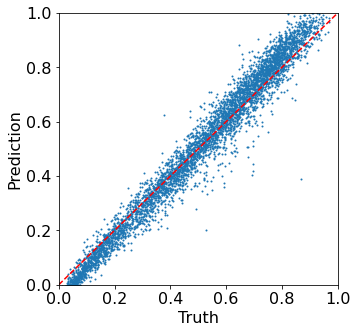

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002831]

INFO: Early stopping counter 4 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [12/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:20<00:00,  4.45it/s, loss=0.0012]


Training acc: 0.000986, Validation accuracy 0.002831


Epoch [13/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.63it/s, loss=0.000244]


Training acc: 0.000970, Validation accuracy 0.002831


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


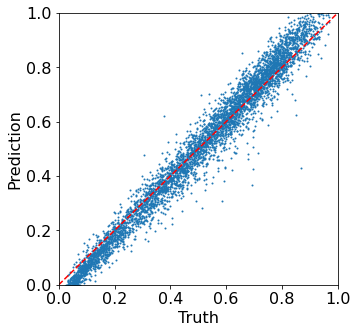

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002610]

INFO: Early stopping counter 5 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [14/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.54it/s, loss=0.000862]


Training acc: 0.000980, Validation accuracy 0.002610


Epoch [15/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.00046]


Training acc: 0.000956, Validation accuracy 0.002610


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


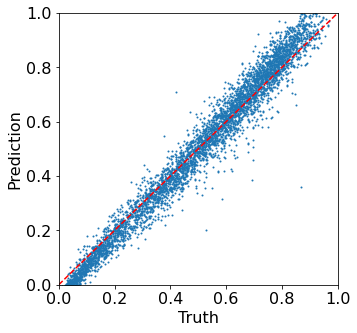

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002642]

INFO: Early stopping counter 6 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [16/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.000703]


Training acc: 0.000938, Validation accuracy 0.002642


Epoch [17/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:11<00:00,  4.74it/s, loss=0.0008]


Training acc: 0.000958, Validation accuracy 0.002642


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


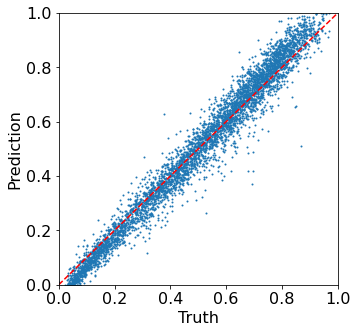

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002525]

INFO: Early stopping counter 7 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [18/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.55it/s, loss=0.000832]


Training acc: 0.000953, Validation accuracy 0.002525


Epoch [19/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.89it/s, loss=0.000633]


Training acc: 0.000943, Validation accuracy 0.002525


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


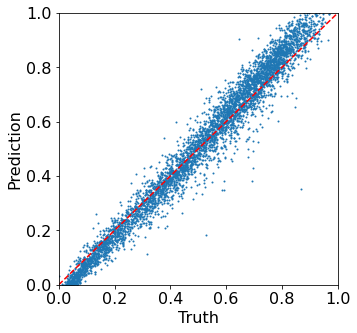

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002901]

INFO: Early stopping counter 8 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [20/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.55it/s, loss=0.000219]


Training acc: 0.000964, Validation accuracy 0.002901


Epoch [21/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.90it/s, loss=0.000849]


Training acc: 0.000934, Validation accuracy 0.002901


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


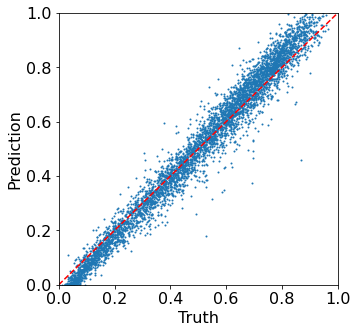

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002708]

INFO: Early stopping counter 9 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [22/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.52it/s, loss=0.00175]


Training acc: 0.000954, Validation accuracy 0.002708


Epoch [23/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:10<00:00,  4.81it/s, loss=0.000299]


Training acc: 0.000937, Validation accuracy 0.002708


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


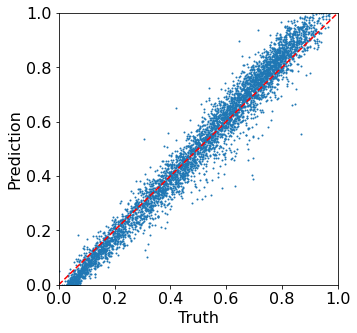

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002753]

INFO: Early stopping counter 10 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [24/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.00106]


Training acc: 0.000902, Validation accuracy 0.002753


Epoch [25/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:06<00:00,  4.94it/s, loss=0.000427]


Training acc: 0.000933, Validation accuracy 0.002753


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


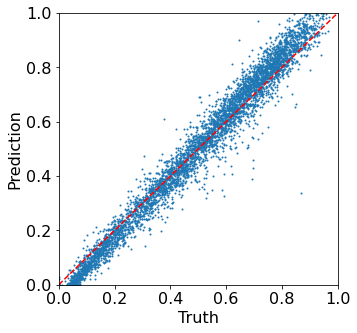

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002716]

INFO: Early stopping counter 11 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [26/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:14<00:00,  4.66it/s, loss=0.000401]


Training acc: 0.000929, Validation accuracy 0.002716


Epoch [27/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:14<00:00,  4.65it/s, loss=0.000402]


Training acc: 0.000904, Validation accuracy 0.002716


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


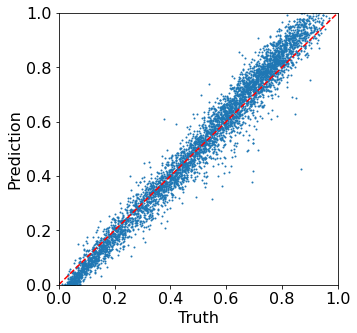

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002804]

INFO: Early stopping counter 12 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [28/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.000489]


Training acc: 0.000923, Validation accuracy 0.002804


Epoch [29/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:06<00:00,  4.93it/s, loss=0.00127]


Training acc: 0.000920, Validation accuracy 0.002804


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


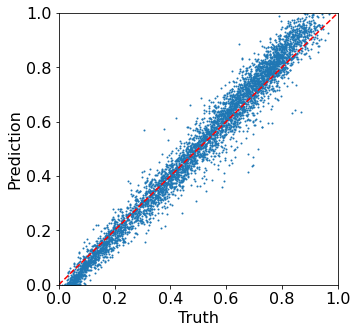

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002636]

INFO: Early stopping counter 13 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [30/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.51it/s, loss=0.000201]


Training acc: 0.000889, Validation accuracy 0.002636


Epoch [31/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.87it/s, loss=0.000627]


Training acc: 0.000906, Validation accuracy 0.002636


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


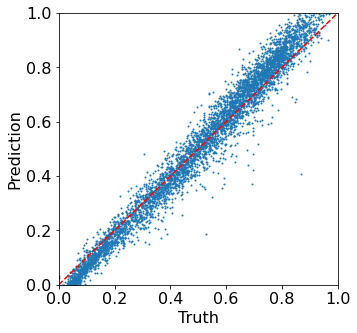

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002952]

INFO: Early stopping counter 14 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [32/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.57it/s, loss=0.00467]


Training acc: 0.000910, Validation accuracy 0.002952


Epoch [33/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.89it/s, loss=0.000897]


Training acc: 0.000906, Validation accuracy 0.002952


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


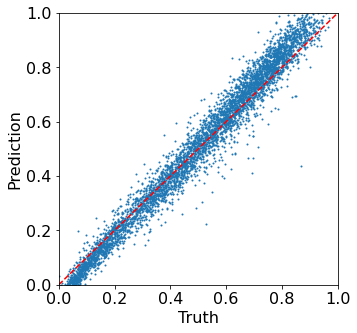

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002779]

INFO: Early stopping counter 15 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [34/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.51it/s, loss=0.00184]


Training acc: 0.000885, Validation accuracy 0.002779


Epoch [35/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:11<00:00,  4.77it/s, loss=0.000669]


Training acc: 0.000886, Validation accuracy 0.002779


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


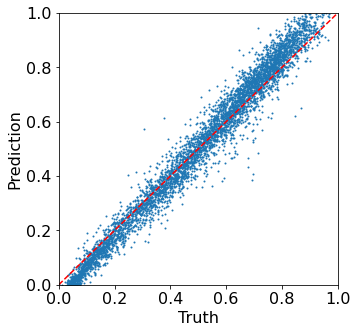

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002742]

INFO: Early stopping counter 16 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [36/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.55it/s, loss=0.000965]


Training acc: 0.000900, Validation accuracy 0.002742


Epoch [37/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.88it/s, loss=0.00272]


Training acc: 0.000869, Validation accuracy 0.002742


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


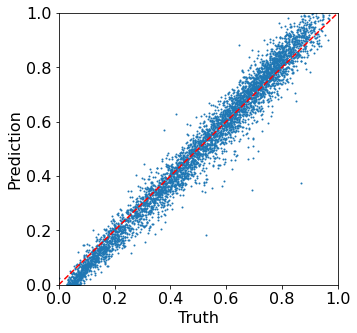

Epoch [38/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.57it/s, loss=0.0012]


Training acc: 0.000884, Validation accuracy 0.002429


Epoch [39/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:14<00:00,  4.67it/s, loss=0.00816]


Training acc: 0.000889, Validation accuracy 0.002429


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


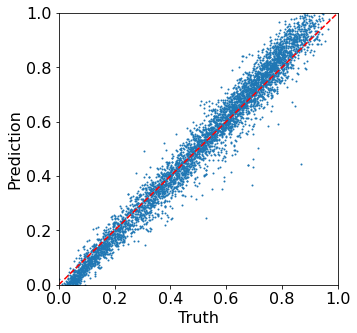

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002571]

INFO: Early stopping counter 17 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [40/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.50it/s, loss=0.000727]


Training acc: 0.000874, Validation accuracy 0.002571


Epoch [41/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:13<00:00,  4.70it/s, loss=0.00119]


Training acc: 0.000876, Validation accuracy 0.002571


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


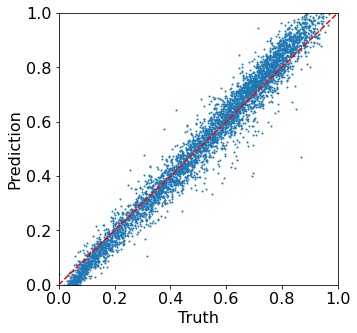

  0%|                                                                                                                                                            | 0/626 [00:07<?, ?it/s, val_acc=0.002504]

INFO: Early stopping counter 18 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [42/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:22<00:00,  4.38it/s, loss=0.00043]


Training acc: 0.000877, Validation accuracy 0.002504


Epoch [43/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:17<00:00,  4.54it/s, loss=0.00109]


Training acc: 0.000871, Validation accuracy 0.002504


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


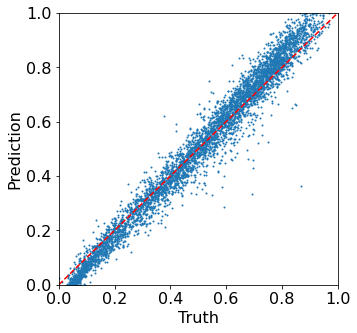

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002643]

INFO: Early stopping counter 19 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [44/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:25<00:00,  4.30it/s, loss=0.000934]


Training acc: 0.000865, Validation accuracy 0.002643


Epoch [45/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:18<00:00,  4.51it/s, loss=0.00174]


Training acc: 0.000863, Validation accuracy 0.002643


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


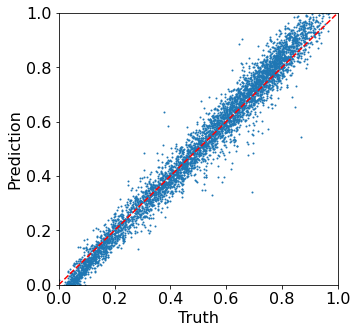

Epoch [46/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:23<00:00,  4.37it/s, loss=0.00193]


Training acc: 0.000870, Validation accuracy 0.002281


Epoch [47/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.000815]


Training acc: 0.000854, Validation accuracy 0.002281


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


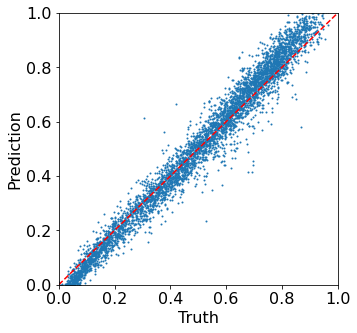

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002581]

INFO: Early stopping counter 20 of 20
INFO: Early stopping


In [23]:
stage = 1
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
# model.unlock_base()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

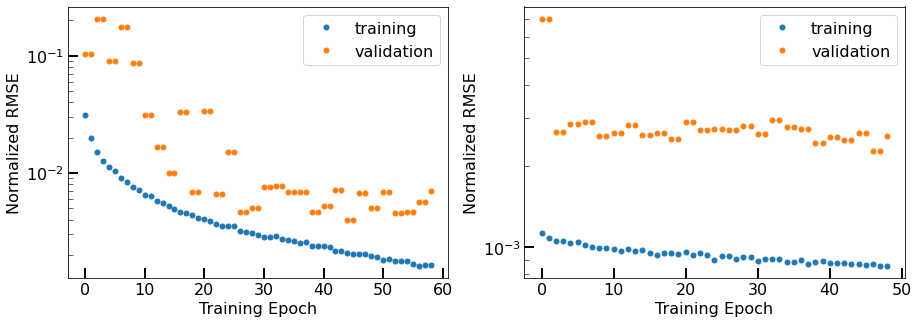

In [24]:
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(121)
ax.plot(np.array(par.process['training'][0]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][0], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 16)
ax.set_ylabel('Normalized RMSE', fontsize = 16)
plt.legend(fontsize = 16)

ax = fig.add_subplot(122)
ax.plot(np.array(par.process['training'][1]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][1], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 16)
ax.set_ylabel('Normalized RMSE', fontsize = 16)
plt.legend(fontsize = 16)

In [25]:
torch.save(model.state_dict(), 'TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt08.pt')
par.save_result('TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt08_')

In [26]:
file = open("TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt08_training_log.pkl",'rb')
object_file = pickle.load(file)
file.close()

In [27]:
print(object_file['training'][0][-1])
print(object_file['validation'][0][-1])
print(object_file['training'][1][-1])
print(object_file['validation'][1][-1])

0.0016425675
0.007059
0.00085408246
0.002581
